In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time
from acquire import player_season_3pa
import explore

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
#calling in the data:
from acquire import tome_prep
df = tome_prep()

In [3]:
#looking at data size and info:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84164 entries, 0 to 94709
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        84164 non-null  object 
 1   player_id     84164 non-null  int64  
 2   team          84164 non-null  object 
 3   team_id       84164 non-null  int64  
 4   game_id       84164 non-null  int64  
 5   home          84164 non-null  bool   
 6   period        84164 non-null  int64  
 7   abs_time      84164 non-null  int64  
 8   play_time     84164 non-null  float64
 9   since_rest    84164 non-null  float64
 10  loc_x         84164 non-null  int64  
 11  loc_y         84164 non-null  int64  
 12  zone          84164 non-null  object 
 13  shot_type     84164 non-null  object 
 14  score_margin  84164 non-null  int64  
 15  points        84164 non-null  int64  
 16  fg_pct        84164 non-null  float64
 17  shot_result   84164 non-null  object 
dtypes: bool(1), float64(3), in

In [4]:
#stats on numeric variables:
df.describe()

,player_id,team_id,game_id,period,abs_time,play_time,since_rest,loc_x,loc_y,score_margin,points,fg_pct
count,8.416400e+04,8.416400e+04,8.416400e+04,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000,84164.000000
mean,1.149216e+06,1.610613e+09,2.210061e+07,2.498123,1446.721104,1063.294047,328.168348,-7.751414,165.757533,0.516183,8.562164,0.530262
std,6.770433e+05,8.585147e+00,3.562261e+02,1.134161,839.909211,593.762525,248.000846,168.748218,93.284885,11.974491,8.140890,0.320773
min,2.544000e+03,1.610613e+09,2.210000e+07,1.000000,6.000000,6.000000,0.300000,-250.000000,-48.000000,-75.000000,0.000000,0.000000
25%,2.034960e+05,1.610613e+09,2.210030e+07,1.000000,716.750000,612.000000,138.000000,-172.000000,79.000000,-6.000000,3.000000,0.320000
50%,1.628370e+06,1.610613e+09,2.210061e+07,2.000000,1440.000000,1025.000000,275.000000,-12.000000,203.000000,0.000000,6.000000,0.500000
75%,1.629643e+06,1.610613e+09,2.210092e+07,3.000000,2160.000000,1466.000000,456.000000,156.000000,241.000000,7.000000,12.000000,0.750000
max,1.630994e+06,1.610613e+09,2.210123e+07,7.000000,3771.000000,3247.000000,2742.000000,250.000000,299.000000,78.000000,79.000000,1.000000


### Univariates:

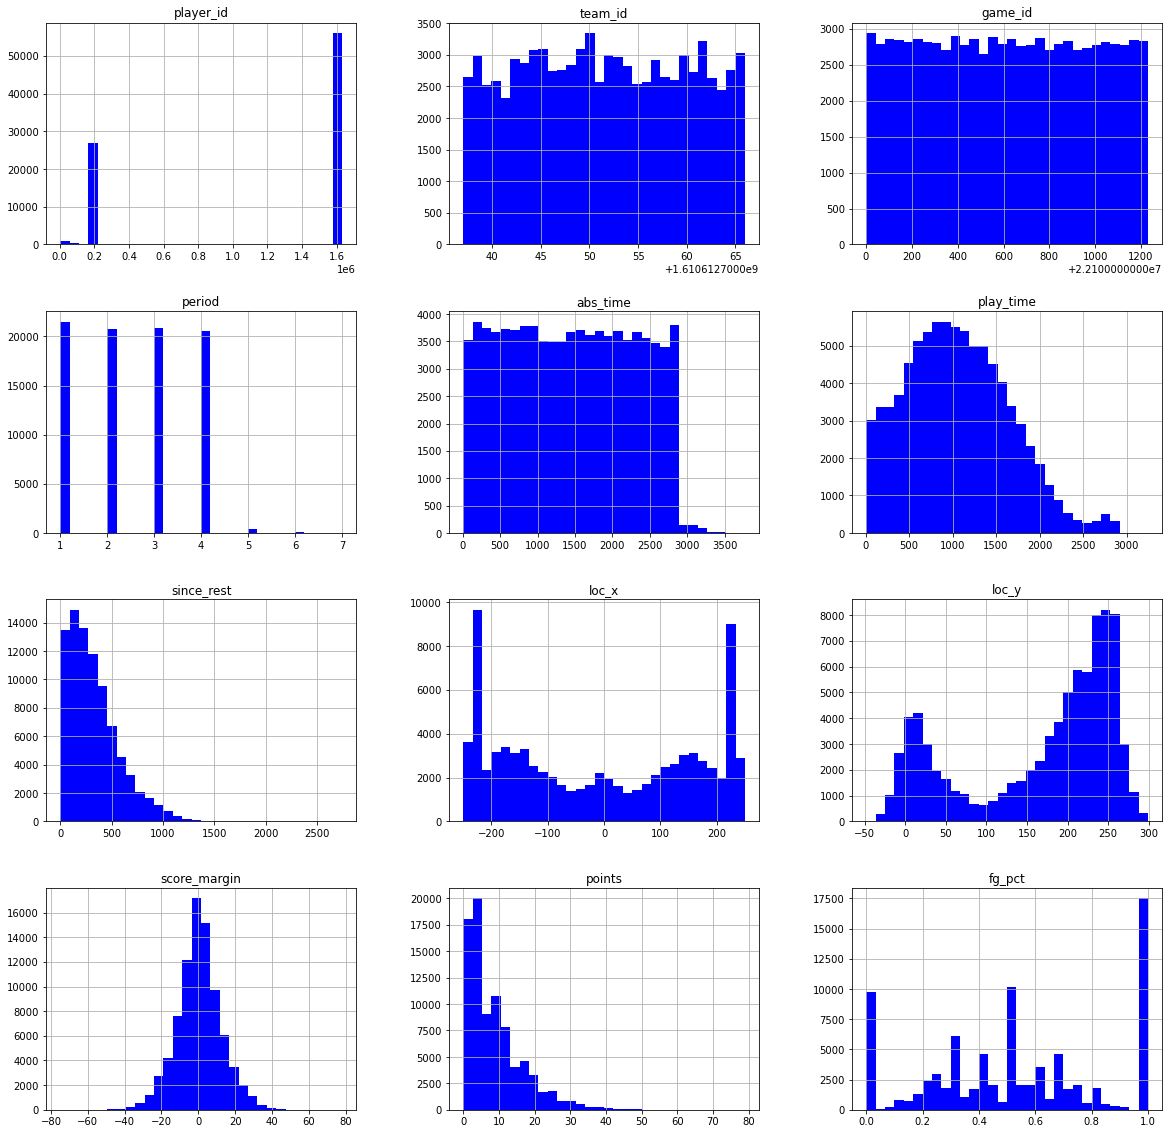

In [5]:
#what is the shape of the numeric data? 
explore.univariate(df)

### Takeaways:
- Play and rest times have clear right-skewed data.
- it is interesting to see that 3pt shots are happening more often in certain locations on the court. (see loc_x)
- score margin seems to be normally distributed
- points made by player are right skewed

### Splitting data on train, validate, test to keep integrity of data and only predict on a portion of the data.

In [6]:
#importing splitter function from splitter.py
from splitter import splitter
train, validate, test=splitter(df, target = 'shot_result', train_split_1 = .8, train_split_2 = .7, random_state = 123)

Train = 47131 rows (56.0%) | Validate = 20200 rows (24.0%) | Test = 16833 rows (20.0%)


In [7]:
#checking out what train looks like:
train.head()

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result
22101,Jeff Green,201145,Denver Nuggets,1610612743,22100794,True,1,166,166.0,166.0,-230,-6,R Center,Jump Shot,2,0,0.00,Missed Shot
54605,RJ Barrett,1629628,New York Knicks,1610612752,22101140,True,2,1077,742.0,22.0,200,138,L Below Break/Corner,Jump Shot,0,10,0.83,Missed Shot
12186,Jonas Valanciunas,202685,New Orleans Pelicans,1610612740,22100179,True,1,74,74.0,74.0,-83,257,Center,Jump Shot,-3,0,0.00,Missed Shot
19168,Reggie Bullock,203493,Dallas Mavericks,1610612742,22100954,True,1,369,369.0,369.0,11,267,L Center,Pullup Jump shot,-6,0,0.00,Missed Shot
80553,Bojan Bogdanovic,202711,Utah Jazz,1610612762,22101150,True,3,1697,818.0,257.0,-223,5,R Center,Jump Shot,6,6,0.27,Missed Shot


### Exploring Target Variable: shot result

In [63]:
#looking at values:
df.shot_result.value_counts()

Missed Shot    54099
Made Shot      30065
Name: shot_result, dtype: int64

In [64]:
#putting into percentages:
df.shot_result.value_counts(normalize=True)

Missed Shot    0.642781
Made Shot      0.357219
Name: shot_result, dtype: float64

In [65]:
#looking at overall Made shot rate:
made_shot_rate=df.shot_result.value_counts(normalize=True)[1]

### Overall Made shot rate is 36%

I want to see the rates based on:
- Player(missed/made)
- Team
- Game
- Shot type
- Period

In [66]:
#using a function by Stephen FitzSimon that takes in a predicted outcome
#and returns the rate based on the feature against target variable:

def get_pct_outcome(df, shot_cols = ['player']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'player_name': cat,
                    'sub_col': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(df)

,player_name,sub_col,outcome,total_shots_made,proportion
0,player,Bogdan Bogdanovic,Made Shot,169,0.373894
1,player,Bogdan Bogdanovic,Missed Shot,283,0.626106
2,player,Cam Reddish,Made Shot,65,0.357143
3,player,Cam Reddish,Missed Shot,117,0.642857
4,player,Cameron Oliver,Made Shot,1,0.333333
...,...,...,...,...,...
1105,player,Miles Bridges,Missed Shot,299,0.660044
1106,player,P.J. Washington,Made Shot,110,0.370370
1107,player,P.J. Washington,Missed Shot,187,0.629630
1108,player,Terry Rozier,Made Shot,219,0.374359


In [67]:
#creating an object to ask questions on:
proportion_df = get_pct_outcome(df)

# Regular Season Leaders

### Which players have the higher 3pt shot 'Made  Shot' rates?

In [77]:
top_3pt_shooters = proportion_df[(proportion_df.proportion > made_shot_rate) & (proportion_df.outcome == 'Made Shot')]
top_3pt_shooters[top_3pt_shooters.total_shots_made >= 87].sort_values(by='proportion', ascending=False).head(60)

,player_name,sub_col,outcome,total_shots_made,proportion
388,player,Luke Kennard,Made Shot,187,0.450602
730,player,Tyrese Maxey,Made Shot,128,0.439863
980,player,Desmond Bane,Made Shot,226,0.437984
196,player,Lonzo Ball,Made Shot,110,0.428016
736,player,Cameron Johnson,Made Shot,165,0.426357
588,player,Seth Curry,Made Shot,156,0.425068
394,player,Norman Powell,Made Shot,104,0.424490
700,player,Tyrese Haliburton,Made Shot,153,0.423823
834,player,Doug McDermott,Made Shot,108,0.421875
580,player,Kyrie Irving,Made Shot,95,0.418502


### What is the average of 3pt 'Made Shots' per season?

In [70]:
#determining average of 3pt shots made per season:
top_3pt_shooters.total_shots_made.mean()

87.45544554455445

### Takeaways:
This gives us a good list of players that are shooting higher than the 35.7% made-shot rate of the NBA overall.

I'll take out the the 1 shot-wonders however, so as not to skew the data.

In [69]:
#looking at value_counts()
top_3pt_shooters.total_shots_made.value_counts()

1      9
4      6
15     5
37     4
8      4
      ..
68     1
129    1
264    1
204    1
219    1
Name: total_shots_made, Length: 127, dtype: int64

_____________________________________________

### Which teams have the highest rate of making 3pt shots?

In [71]:
### Looking a proportions of 3pt shots based on teams:
def get_pct_outcome(df, shot_cols = ['col']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'main_category': cat,
                    'sub_category': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(df, shot_cols= ['team'])

,main_category,sub_category,outcome,total_shots_made,proportion
0,team,Atlanta Hawks,Made Shot,1004,0.380015
1,team,Atlanta Hawks,Missed Shot,1638,0.619985
2,team,New York Knicks,Made Shot,1077,0.359719
3,team,New York Knicks,Missed Shot,1917,0.640281
4,team,Los Angeles Lakers,Made Shot,958,0.347731
5,team,Los Angeles Lakers,Missed Shot,1797,0.652269
6,team,Indiana Pacers,Made Shot,985,0.348673
7,team,Indiana Pacers,Missed Shot,1840,0.651327
8,team,Chicago Bulls,Made Shot,867,0.374191
9,team,Chicago Bulls,Missed Shot,1450,0.625809


In [72]:
#creating an object to apply to teams:
team_prop_df = get_pct_outcome(df, shot_cols= ['team'])

In [73]:
# result of top teams that make 3pt shots:
top_3pt_teams = team_prop_df[(team_prop_df.proportion > made_shot_rate) & (team_prop_df.outcome == 'Made Shot')]
top_3pt_teams.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
22,team,Miami Heat,Made Shot,1093,0.385130
0,team,Atlanta Hawks,Made Shot,1004,0.380015
44,team,Los Angeles Clippers,Made Shot,1037,0.378882
8,team,Chicago Bulls,Made Shot,867,0.374191
48,team,Golden State Warriors,Made Shot,1145,0.373329
42,team,Milwaukee Bucks,Made Shot,1139,0.368489
36,team,Philadelphia 76ers,Made Shot,932,0.367943
38,team,Charlotte Hornets,Made Shot,1113,0.367691
18,team,Phoenix Suns,Made Shot,944,0.367172
16,team,Utah Jazz,Made Shot,1173,0.365193


______________________

### Which Shot types have higher 3pt shot rates?

In [74]:
shot_type_prop = get_pct_outcome(df, shot_cols= ['shot_type'])
best_shot_types = shot_type_prop[(shot_type_prop.proportion > made_shot_rate) & (shot_type_prop.outcome == 'Made Shot')]
best_shot_types.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
20,shot_type,Jump Bank Shot,Made Shot,85,0.521472
6,shot_type,Running Jump Shot,Made Shot,1093,0.419739
10,shot_type,Running Pull-Up Jump Shot,Made Shot,551,0.403367
26,shot_type,Driving Floating Bank Jump Shot,Made Shot,2,0.400000
16,shot_type,Step Back Bank Jump Shot,Made Shot,11,0.392857


________________

### Which zones have higher rates of shots made?

In [75]:
zone_prop = get_pct_outcome(df, shot_cols= ['zone'])
best_zones = zone_prop[(zone_prop.proportion > made_shot_rate) & (zone_prop.outcome == 'Made Shot')]
best_zones.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
10,zone,R Center,Made Shot,4538,0.383796
0,zone,R Below Break/Corner,Made Shot,4114,0.380891


________________________________

### Hypothesis Tests: 

#### Hypothesis 1): 3pt shots made have a relationship with the type of shot taken.

In [78]:
alpha = 0.05
null_hypothesis = "3pt shot result and shot type are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and shot type"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.shot_result, train.shot_type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and shot type are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and shot type


5.706798758371029e-11

#### Hypothesis 2): 3pt shots made have a relationship with where the shot was taken.

In [79]:
alpha = 0.05
null_hypothesis = "3pt shot result and zone shot from are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and zone shot from"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.shot_result, train.zone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and zone shot from are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and zone shot from


6.428460713417156e-10

#### Hypothesis 3): 3pt shots made have a relationship with how much time a player has been in the game.

In [23]:
shots_made_sample = train[train.shot_result == 'Made Shot'].play_time

<AxesSubplot:>

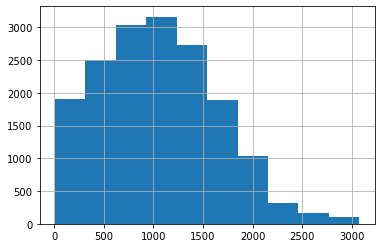

In [26]:
shots_made_sample.hist()

In [25]:
shots_missed_sample = train[train.shot_result == 'Missed Shot'].play_time

<AxesSubplot:>

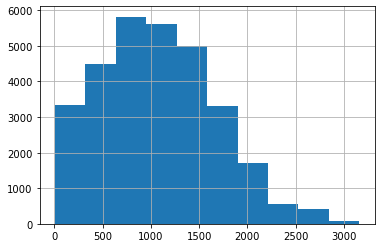

In [27]:
shots_missed_sample.hist()

(array([[1945., 2591., 3166., 3192., 2736., 1821.,  902.,  255.,  200.,
           28.],
        [3325., 4493., 5819., 5623., 4985., 3304., 1706.,  543.,  427.,
           70.]]),
 array([   7.,  322.,  637.,  952., 1267., 1582., 1897., 2212., 2527.,
        2842., 3157.]),
 <a list of 2 BarContainer objects>)

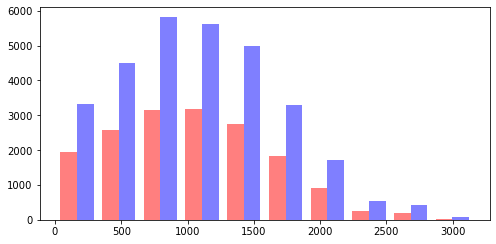

In [49]:
#putting the made vs missed shots on same histogram for comparison:
x = shots_made_sample
y = shots_missed_sample
plt.hist([x, y], color=['r','b'], alpha=0.5)

#### $H_0$ Mean of made shots is higher or equal to the mean of missed shots. 
#### $H_a$ Mean of made shots is less than mean of missed shots

In [28]:
alpha = .05

#checking for equal variances:
print(shots_made_sample.var())
print(shots_missed_sample.var())


345242.44129942806
354140.78363731335


Variances are not quite equal so we will use equal_var as False:

In [29]:
t, p = stats.ttest_ind(shots_made_sample, shots_missed_sample, equal_var=False)
t, p / 2

(-3.8003146850502674, 7.23780039169281e-05)

In [30]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)

is p/2 < alpha?  True
is t > 0?  False


In [31]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")


We fail to reject $H_{0}$


#### Takeaway: It looks like the amount of time in game does not relate to when a 3pt shot was made.

______________________________

#### Hypothesis 4): 3pt shots made have a relationship with how much time a player had rested prior to the shoot.

In [33]:
shots_made_rest = train[train.shot_result == "Made Shot"].since_rest

<AxesSubplot:>

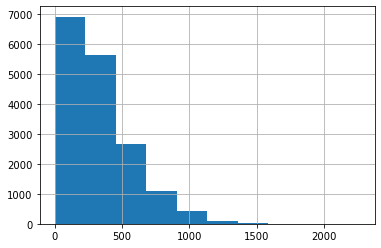

In [35]:
shots_made_rest.hist()

In [34]:
shots_missed_rest = train[train.shot_result == "Missed Shot"].since_rest

<AxesSubplot:>

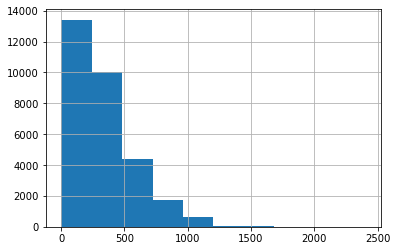

In [36]:
shots_missed_rest.hist()

The shapes look very similar. Let's look at variances:

#### $H_0$ Mean of made shots is higher or equal to the mean of missed shots. 
#### $H_a$ Mean of made shots is less than mean of missed shots.

In [38]:
alpha = .05

#checking for equal variances:
print(shots_made_rest.var())
print(shots_missed_rest.var())

60308.55468256225
62295.31679105733


In [40]:
#variances not the same so var will equal false in test:
t, p = stats.ttest_ind(shots_made_rest, shots_missed_rest, equal_var=False)
t, p / 2

(0.4176928733497884, 0.3380871136443081)

In [41]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)

is p/2 < alpha?  False
is t > 0?  True


In [42]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We fail to reject $H_{0}$


_____________________________________

## Rechecking with more confidence in alpha and ANOVA testing 
for Missed vs Made and play time 

I want to make sure there isn't some odd randomness happening, so I'll use both the Missed and Made shots and do an Anova test with 99% accuracy check if there isn't something odd going on between the variables.

I can tell on the histograms there is a difference happening, but maybe the 95% confidence in alpha needs to be set differently as the metrics may be close but still varying. We want to find/see that.

In [43]:
null_hypothesis = "Amount of time played when taking a 3pt shot has no relation to when shot is made or missed"
alternative_hypothesis = "Amount of time played when taking a 3pt shot has a relation to when shot is made or missed"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [44]:
# Isolating out made vs missed shots:
made_shots = train[train.shot_result == "Made Shot"].play_time
missed_shots = train[train.shot_result == "Missed Shot"].play_time

In [45]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(made_shots, missed_shots)
p

0.00015295398137427682

In [46]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that play time averages are significantly different across made or missed shots.")

We reject the null hypothesis that Amount of time played when taking a 3pt shot has no relation to when shot is made or missed
We move forward with the alternative hypothesis that Amount of time played when taking a 3pt shot has a relation to when shot is made or missed


______________________________